In [57]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from wordcloud import WordCloud

In [2]:
# Chose the benchmark from spec, spec-stripped, spec-opt and spec-opt-stripped.

class BenchmarkType():
    path = None
    clean_dict = {}
    callsite_dict = {}
    fun_dict = {}
    model_stat = {}

In [8]:
def ParaseBenchmarks(bench):
    benchmark_type = BenchmarkType()
    path = f"/volatile/zephyr/Ruturaj/cfi_project/test_suite/{bench}/"
    benchmarks = ["400.perlbench", "401.bzip2", "403.gcc.hs", "445.gobmk", "456.hmmer", \
                  "458.sjeng.hs", "464.h264ref.hs"]
    binaries = ["perlbench-debug.exe", "bzip2.exe", "gcc.exe", "gobmk.exe", "hmmer.exe", \
                "sjeng.exe", "h264ref.exe"]

    clean_dict = {}
    callsite_dict = {}
    fun_dict = {}

    for i, benchmark in enumerate(benchmarks):

        clean_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-clean.csv"), index_col=0, header=[0])
        fun_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-fun-clean.csv"), \
                             header=[0])
        callsite_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-callsite-clean.csv"), \
                                  index_col=0, header=[0])

        ######## Clean clean_df and store. ########

        # Drop rows with Nan values. Note: this could remove the ligimate callsites.
        clean_df = clean_df.dropna(how="any")

        # Sort the dataframe on "Params".
        clean_df = clean_df.sort_values("Params")

        # add SrcType (IFCC)_ida if absent
        if "SrcType (IFCC)_ida" not in clean_df:
            clean_df["SrcType (IFCC)_ida"] = 0
        if "SafeSrcType (IFCC-safe)_ida" not in clean_df:
            clean_df["SafeSrcType (IFCC-safe)_ida"] = 0

        # Convert the dataframe type to int (for all the columns).
        columns = ["Params_ida", "SrcType (IFCC)_ida", "SafeSrcType (IFCC-safe)_ida", "BinType (TypeArmor)_ida", \
                  "Baseline_ida"]
        clean_df[columns] = clean_df[columns].astype(int)

        # Calculate differences in each column.
        clean_df["Param_match"] = np.where(clean_df["Params"] == clean_df["Params_ida"], 1, 0)
        clean_df["SrcType_match"] = np.where(clean_df["SrcType (IFCC)"] == clean_df["SrcType (IFCC)_ida"], 1, 0)
        clean_df["SafeSrcType_match"] = np.where(clean_df["SafeSrcType (IFCC-safe)"] \
                                        == clean_df["SafeSrcType (IFCC-safe)_ida"], 1, 0)
        clean_df["BinType_match"] = np.where(clean_df["BinType (TypeArmor)"] \
                                             == clean_df["BinType (TypeArmor)_ida"], 1, 0)

        clean_dict[benchmark] = clean_df

        ######## Clean callsite_df and store. ########

        # Drop rows with Nan values. Note: this could remove the ligimate callsites.
        callsite_df = callsite_df.dropna(how="any")

        # Convert the dataframe type to int (for all the columns).
        columns = ["Arg1_ida", "Arg2_ida", "Arg3_ida", "Arg4_ida", "Arg5_ida", \
                   "Arg6_ida", "Arg7_ida", "Return_ida"]
        callsite_df[columns] = callsite_df[columns].astype(int)

        callsite_dict[benchmark] = callsite_df

        ######## Clean fun_df and store. ########

        fun_dict[benchmark] = fun_df
    benchmark_type.path = path
    benchmark_type.clean_dict = clean_dict
    benchmark_type.callsite_dict = callsite_dict
    benchmark_type.fun_dict = fun_dict
    
    return benchmark_type

spec = ParaseBenchmarks("spec")
spec_str = ParaseBenchmarks("spec-stripped")
spec_opt = ParaseBenchmarks("spec-opt")
spec_opt_str = ParaseBenchmarks("spec-opt-stripped")

In [20]:
def displayTargets(bench, obj):
    print("\\begin{table*}[t]")
    print("\\centering")
    def matchTable(match_type, match_type_ida):
        match_count = {}
        for benchmark, df in obj.clean_dict.items():
            llvm_arr = df[match_type].to_numpy()
            ida_arr = df[match_type_ida].to_numpy()
            match_count[benchmark] = df[match_type].describe(percentiles=[.9]).to_list()
            match_count[benchmark].extend(df[match_type_ida].describe(percentiles=[.9]).to_list()[1:])
        headers = ["Benchmark", "Count", "Mean", "Std", "Min", "Med", "90thp", "Max", \
                  "Mean", "Std", "Min", "Med", "90thp", "Max"]
        table = tabulate([[k]+[int(x) if not np.isnan(x) else x for x in v] for k,v in match_count.items()], \
                       headers=headers, tablefmt="latex")
        print("\\resizebox{\\columnwidth}{!}{")
        table = table.split("\n")
        # replace first row with custom latex statement.
        table[0] = "\\begin{tabular}[t]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}"
        # First print only two rows.
        [print(line) for line in table[:2]]
        print("\\multicolumn{2}{|c||}{} & \\multicolumn{6}{|c||}{LLVM-CFI} "
        "& \\multicolumn{6}{|c|}{Binary-CFI}\\\\")
        print("\\hline")
        [print(line) for line in table[2:]]
        print("}")

    # matchTable("Param_match")

    matchTable("BinType (TypeArmor)", "BinType (TypeArmor)_ida")

    matchTable("SafeSrcType (IFCC-safe)", "SafeSrcType (IFCC-safe)_ida")

    matchTable("SrcType (IFCC)", "SrcType (IFCC)_ida")
    
    debug = "out" if "stripped" in bench else ""
    print("\caption{Comparison of 3 different policies ({\it TypeArmor}, {\it Safe IFCC}, {\it IFCC})"
                  f"applied for binaries compiled with{debug} debug symbols. "
                   "The count depicts number of callsites, and subsequent columns display Mean, Standard "
                   "Deviation, Minimum, Median, 90\\textsuperscript{th} percentile and Maximum aggregate "
                   f"results for each {bench} benchmark.}}")
    print(f"\\label{{table:{bench}}}")
    print("\\end{table*}")
    
displayTargets("spec", spec)

\begin{table*}[t]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}[t]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}
\hline
\multicolumn{2}{|c||}{} & \multicolumn{6}{|c||}{LLVM-CFI} & \multicolumn{6}{|c|}{Binary-CFI}\\
\hline
 Benchmark      &   Count &   Mean &   Std &   Min &   Med &   90thp &   Max &   Mean &   Std &   Min &   Med &   90thp &   Max \\
\hline
 400.perlbench  &      97 &    935 &   263 &   384 &  1055 &    1249 &  1293 &    931 &   275 &   386 &  1049 &    1250 &  1293 \\
 401.bzip2      &      20 &     67 &     5 &    63 &    63 &      73 &    73 &     56 &    11 &    44 &    58 &      69 &    69 \\
 403.gcc.hs     &     249 &   1595 &   615 &   107 &  1891 &    2008 &  2920 &   1800 &   570 &   139 &  1889 &    2482 &  2920 \\
 445.gobmk      &      40 &   1625 &   844 &   214 &  2126 &    2165 &  2198 &   1623 &   852 &   214 &  2121 &    2179 &  2198 \\
 456.hmmer      &       9 &    226 &     0 &   226 &   226 &     226 &   226 &    230 &    24 &   214 &   214 &    

In [21]:
def collectMetrics(bench, obj):
    path = obj.path
    benchmarks = ["400.perlbench", "401.bzip2", "403.gcc.hs", "445.gobmk", "456.hmmer", \
              "458.sjeng.hs", "464.h264ref.hs"]
    binaries = ["perlbench-debug.exe", "bzip2.exe", "gcc.exe", "gobmk.exe", "hmmer.exe", \
                "sjeng.exe", "h264ref.exe"]

    metric_dict = {}

    def convertDwarf(dwarf):
        return ":".join(dwarf.split(":", 2)[:2])

    def addr2line(bin, path, df) -> list:
        dwarf = []
        for _,row in df.iterrows():
            cmd = ["addr2line", "-e", bin, "-f", row.iloc[0]]
            dwarflines = subprocess.check_output(cmd)
            function, dwarfline = dwarflines.splitlines()
            if function.decode() == "??" or dwarfline.decode() == "??:?":
                dwarf.append(np.nan)
                continue
            # Remove **(discriminator 7)** which appears in addr2line output.
            # For e.g. perlio.c:1375 (discriminator 7).
            dwarfline = dwarfline.split()[0]
            dwarf.append(dwarfline.decode().split(path.split("/")[-1])[-1][1:])
        return dwarf

    def iterateRows(df, index):
        dic = {}
        for _,row in df.iterrows():
            k = row.iloc[0]
            dic[k] = {"ifcc":set(), "ifccsafe":set(), "typearmor":set()}
            # Extract number of functions for IFCC approach.
            # IFCC functions start from "18" column for llvm and "19" for ida,
            # which is well known seeing the dataframes.
            # Thus first calculate IFCC functions and then look for the others.
            idx = index
            ifcc_funs = int(row.iloc[idx][row.iloc[idx].find("(")+1:row.iloc[idx].find(")")])
            for i in range(idx+1, idx+ifcc_funs+1):
                dic[k]["ifcc"].add(row.iloc[i])
            idx = idx + ifcc_funs + 1
            ifccsafe_funs = int(row.iloc[idx][row.iloc[idx].find("(")+1:row.iloc[idx].find(")")])
            for i in range(idx+1, idx+ifccsafe_funs+1):
                dic[k]["ifccsafe"].add(row.iloc[i])
            idx = idx + ifccsafe_funs + 1
            typearmor_funs = int(row.iloc[idx][row.iloc[idx].find("(")+1:row.iloc[idx].find(")")])
            for i in range(idx+1, idx+typearmor_funs+1):
                dic[k]["typearmor"].add(row.iloc[i])
        return dic

    for i, benchmark in enumerate(benchmarks):
        print(benchmark)
        delimiter = ','
        max_columns = max(open(os.path.join(path+benchmark+"/SDOutput", binaries[i] + \
                                "-Indirect-metric.csv"), 'r'), \
                          key = lambda x: x.count(delimiter)).count(delimiter)
        metric_df = pd.read_csv(os.path.join(path+benchmark+"/SDOutput", binaries[i] + \
                                "-Indirect-metric.csv"),\
                                sep=',', lineterminator='\n', names = list(range(0,max_columns+1)),\
                               skiprows=[0,1])
        metric_df.iloc[:,0] = metric_df.iloc[:,0].apply(convertDwarf)

        max_columns = max(open(os.path.join(path+benchmark+"/IDAoutput", binaries[i] + \
                                "-Indirect-metric.csv"), 'r'), \
                          key = lambda x: x.count(delimiter)).count(delimiter)
        ida_metric_df = pd.read_csv(os.path.join(path+benchmark+"/IDAoutput", binaries[i] + \
                                "-Indirect-metric.csv"),\
                                sep=',', lineterminator='\n', names = list(range(0,max_columns+1)), \
                                   dtype=object, skiprows=[0,1])

        # Compute dwarf information using addr2line tool for ida generated df.
        # The first argument will atlways be a binary with debug information - thus using replace.
        if "spec-stripped" in bench:
            dwarf = addr2line(os.path.join(path.replace("spec-stripped", "spec"), benchmark+"/"+binaries[i]), \
                os.path.join(path, benchmark), ida_metric_df)
        elif "spec-opt-stripped" in bench:
            dwarf = addr2line(os.path.join(path.replace("spec-opt-stripped", "spec-opt"), \
                benchmark+"/"+binaries[i]), \
                os.path.join(path, benchmark), ida_metric_df)
        else:
            dwarf = addr2line(os.path.join(path, benchmark+"/"+binaries[i]), \
                os.path.join(path, benchmark), ida_metric_df)
        ida_metric_df.insert(loc=0, column=("Dwarf"), value=dwarf)

        metric_dict[benchmark] = {}
        metric_dict[benchmark]["llvm"] = iterateRows(metric_df, 18)
        metric_dict[benchmark]["ida"] = iterateRows(ida_metric_df, 19)
        metric_dict[benchmark]["baseline_llvm"] = metric_df.iloc[:1,10][0]
        metric_dict[benchmark]["baseline_ida"] = int(ida_metric_df.iloc[:1,11][0])
    
    def exactMatch():
        model_stat = {}
        for benchmark, graph_type in metric_dict.items():
            model_stat[benchmark] = {"ifcc":{"tp":[],"tn":[], "fp":[]}, \
                                     "ifccsafe":{"tp":[],"tn":[], "fp":[]},\
                                     "typearmor":{"tp":[],"tn":[], "fp":[]}}
            for callsite, models in graph_type["ida"].items():
                if callsite in graph_type["llvm"]:
                    # ifcc model
                    # if no function is allowed at callsite, then check whether
                    # ida displays then mark both tp and tn 0.
                    if len(graph_type["llvm"][callsite]["ifcc"]) == 0:
                        model_stat[benchmark]["ifcc"]["tp"].append(0)
                        model_stat[benchmark]["ifcc"]["tn"].append(0)
                    else:
                        model_stat[benchmark]["ifcc"]["tp"]\
                        .append(len(models["ifcc"]&graph_type["llvm"][callsite]["ifcc"])\
                                /len(graph_type["llvm"][callsite]["ifcc"]))
                        model_stat[benchmark]["ifcc"]["tn"]\
                        .append(len(graph_type["llvm"][callsite]["ifcc"]-models["ifcc"])\
                               /len(graph_type["llvm"][callsite]["ifcc"]))
                    numerator = graph_type["baseline_llvm"]-len(graph_type["llvm"][callsite]["ifcc"])
                    if numerator == 0:
                        model_stat[benchmark]["ifcc"]["fp"].append(0)
                    else:
                        model_stat[benchmark]["ifcc"]["fp"]\
                        .append(len(models["ifcc"]-graph_type["llvm"][callsite]["ifcc"])\
                               /numerator)

                    # ifccsafe model
                    # if no function is allowed at callsite, then check whether
                    # ida displays the same if not then it is a false negative.
                    if len(graph_type["llvm"][callsite]["ifccsafe"]) == 0:
                        model_stat[benchmark]["ifccsafe"]["tp"].append(0)
                        model_stat[benchmark]["ifccsafe"]["tn"].append(0)
                    else:
                        model_stat[benchmark]["ifccsafe"]["tp"]\
                        .append(len(models["ifccsafe"]&graph_type["llvm"][callsite]["ifccsafe"])\
                                /len(graph_type["llvm"][callsite]["ifccsafe"]))
                        model_stat[benchmark]["ifccsafe"]["tn"]\
                        .append(len(graph_type["llvm"][callsite]["ifccsafe"]-models["ifccsafe"])\
                               /len(graph_type["llvm"][callsite]["ifccsafe"]))
                    numerator = graph_type["baseline_llvm"]-len(graph_type["llvm"][callsite]["ifccsafe"])
                    if numerator == 0:
                        model_stat[benchmark]["ifccsafe"]["fp"].append(0)
                    else:
                        model_stat[benchmark]["ifccsafe"]["fp"]\
                        .append(len(models["ifccsafe"]-graph_type["llvm"][callsite]["ifccsafe"])\
                               /numerator)

                    # typearmor model
                    model_stat[benchmark]["typearmor"]["tp"]\
                    .append(len(models["typearmor"]&graph_type["llvm"][callsite]["typearmor"])\
                            /len(graph_type["llvm"][callsite]["typearmor"]))
                    model_stat[benchmark]["typearmor"]["tn"]\
                    .append(len(graph_type["llvm"][callsite]["typearmor"]-models["typearmor"])\
                           /len(graph_type["llvm"][callsite]["typearmor"]))
                    numerator = graph_type["baseline_llvm"]-len(graph_type["llvm"][callsite]["typearmor"])
                    if numerator == 0:
                        model_stat[benchmark]["typearmor"]["fp"].append(0)
                    else:
                        model_stat[benchmark]["typearmor"]["fp"]\
                        .append(len(models["typearmor"]-graph_type["llvm"][callsite]["typearmor"])\
                               /numerator)
        obj.model_stat = model_stat
    exactMatch()

collectMetrics("spec", spec)

400.perlbench
401.bzip2
403.gcc.hs


/tmp/ipykernel_734111/2842585290.py:57: DtypeWarning: Columns (2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946) have mixed types. Specify dtype option on import or set low_memory=False.
  metric_df = pd.read_csv(os.path.join(path+benchmark+"/SDOutput", binaries[i] + \


445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs


In [91]:
print("\\begin{table*}[t]")
print("\\centering")
def exactMatchTable(bench, obj):
    model_stat = obj.model_stat
    
    match_count = {}
    for benchmark, model in model_stat.items():
        print(benchmark)
        match_count[benchmark] = pd.Series(model["ifcc"]["tp"]).describe(percentiles=[.9]).to_list()
        match_count[benchmark].extend(pd.Series(model["ifcc"]["fp"]).describe(percentiles=[.9])[1:])
    headers = ["Benchmark", "Count", "Mean", "Std", "Min", "Med", "25thp", "Max", \
        "Mean", "Std", "Min", "Med", "90thp", "Max"]
    table = tabulate([[k]+v for k,v in match_count.items()], \
        headers=headers, tablefmt="latex")
    print("\\resizebox{\\columnwidth}{!}{")
    table = table.split("\n")
    # replace first row with custom latex statement.
    table[0] = "\\begin{tabular}[t]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}"
    # First print only two rows.
    [print(line) for line in table[:2]]
    print("\\multicolumn{2}{|c||}{} & \\multicolumn{6}{|c||}{LLVM-CFI} "
        "& \\multicolumn{6}{|c|}{Binary-CFI}\\\\")
    print("\\hline")
    [print(line) for line in table[2:]]
    print("}")

    debug = "out" if "stripped" in bench else ""
    print("\caption{Comparison of 3 different policies ({\it TypeArmor}, {\it Safe IFCC}, {\it IFCC})"
      f"applied for binaries compiled with{debug} debug symbols. "
       "The count depicts number of callsites, and subsequent columns display Mean, Standard "
       "Deviation, Minimum, Median, 90\\textsuperscript{th} percentile and Maximum aggregate "
       f"results for each {bench} benchmark.}}")
    print(f"\\label{{table:{bench}}}")
    print("\\end{table*}")

exactMatchTable("spec", spec)

\begin{table*}[t]
\centering
400.perlbench
401.bzip2
403.gcc.hs
445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs
\resizebox{\columnwidth}{!}{
\begin{tabular}[t]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}
\hline
\multicolumn{2}{|c||}{} & \multicolumn{6}{|c||}{LLVM-CFI} & \multicolumn{6}{|c|}{Binary-CFI}\\
\hline
 Benchmark      &   Count &     Mean &        Std &   Min &      Med &    25thp &   Max &       Mean &          Std &   Min &       Med &       90thp &        Max \\
\hline
 400.perlbench  &      97 & 0.564536 &   0.495943 &     0 & 0.987342 & 1        &     1 & 0.00415481 &   0.0195712  &     0 & 0         & 0.0086072   & 0.137562   \\
 401.bzip2      &      20 & 0.2      &   0.410391 &     0 & 0        & 1        &     1 & 0.00689655 &   0.0057773  &     0 & 0.0114943 & 0.0114943   & 0.0114943  \\
 403.gcc.hs     &     249 & 0.385938 &   0.339378 &     0 & 0.487179 & 0.931054 &     1 & 0.0137059  &   0.0309291  &     0 & 0         & 0.0849602   & 0.0849602  \\
 445.gobmk      &      

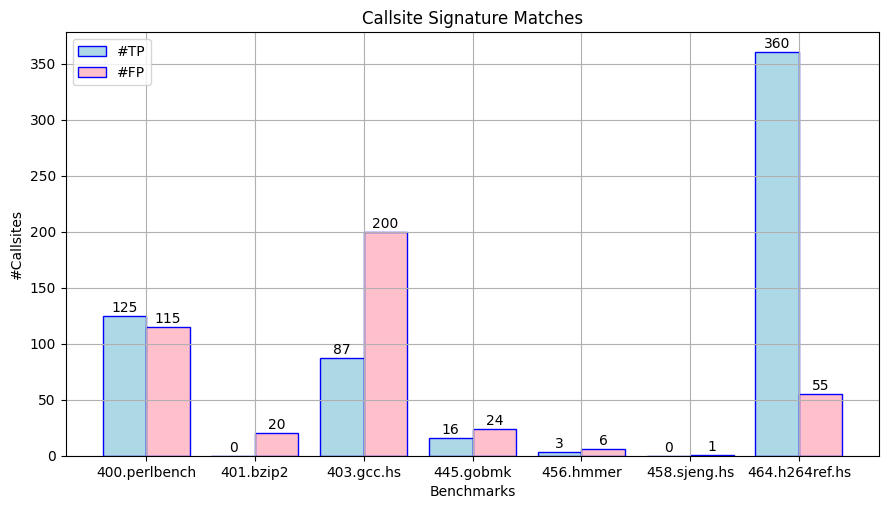

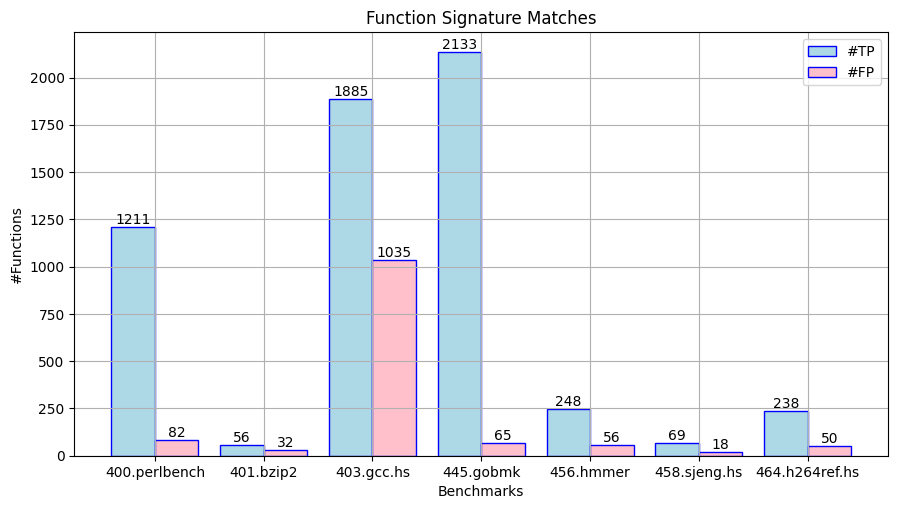

In [77]:
def signaturePlot(bench, obj, graph_type):
    if graph_type == "Callsite":
        dic = obj.callsite_dict
    else:
        dic = obj.fun_dict
    
    cols = ["Arg1", "Arg2", "Arg3", "Arg4", "Arg5", \
               "Arg6", "Arg7", "Return"]
    cols_ida = ["Arg1_ida", "Arg2_ida", "Arg3_ida", "Arg4_ida", "Arg5_ida", \
               "Arg6_ida", "Arg7_ida", "Return_ida"]
    match_count = {}
    for benchmark, df in dic.items():
        match_count[benchmark] = (df[cols].values == df[cols_ida].values).all(axis=1).astype(int)
        match_count[benchmark] = dict(zip(*np.unique(match_count[benchmark], return_counts=True)))
        if not 1 in match_count[benchmark]: match_count[benchmark][1] = 0
        if not 0 in match_count[benchmark]: match_count[benchmark][0] = 0

    # sorted by key, return a list of tuples
    lists = sorted(match_count.items())
    x, y = zip(*lists)
    y2, y1 = zip(*[[item[1] for item in sorted(li[1].items())] for li in lists])
    
    # Set the bar width.
    w = 0.4
    
    bar1 = np.arange(len(x))
    bar2 = [i+w for i in bar1]
    
    fig, ax = plt.subplots()
    
    fig.set_dpi(100)
    fig.set_size_inches(10.5, 5.5)
    
    color = ['red','blue','green','orange']
    
    ax_bar1 = ax.bar(bar1, y1,w, label="#TP", color="lightblue", edgecolor="b")
    ax_bar2 = ax.bar(bar2, y2,w, label="#FP", color="pink", edgecolor="b")
    
    ax.set_xticks(bar1+w/2, x)
    ax.set_ylabel(f"#{graph_type}s")
    ax.set_xlabel("Benchmarks")
    ax.set_title(f"{graph_type} Signature Matches")
    ax.legend()
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom')
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    plt.grid()
    plt.show()
    plt.close(fig)
signaturePlot("spec", spec, "Callsite")
signaturePlot("spec", spec, "Function")

400.perlbench
401.bzip2
403.gcc.hs
445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs


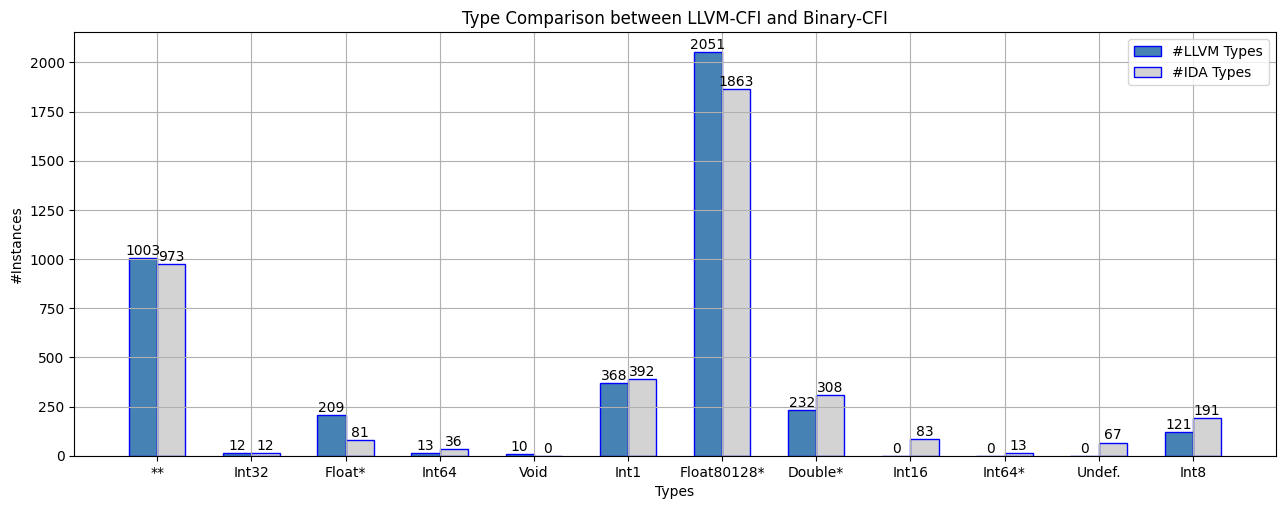

In [135]:
def decode(encoding, recurse):
    ret = ""
    if encoding == 1:
        ret = "Void"
    elif encoding == 2:
        ret = "Int1"
    elif encoding == 3:
        ret = "Int8"
    elif encoding == 4:
        ret = "Int16"
    elif encoding == 5:
        ret = "Int32"
    elif encoding == 6:
        ret = "Int64"
    elif encoding == 7:
        ret = "Half"
    elif encoding == 8:
        ret = "Float"
    elif encoding == 9:
        ret = "Double"
    elif encoding == 10:
        ret = "Float80128"
    elif encoding == 12:
        ret = "Struct"
    elif encoding == 13:
        ret = "Array"
    elif encoding == 14:
        ret = "Undef."
    else:
        if recurse: 
            ret = decode(encoding-11, False)
        ret += "*"
    return ret

def worldCloudPlot(bench, obj):
    dic = obj.callsite_dict
    type_llvm = {}
    type_ida = {}
    types = set()
    types_ida = set()
    for benchmark, df in dic.items():
        print(benchmark)
        for index, row in df.iterrows():
            # Collct and store llvm types - first 1-9 cols.
            for i in range(1,9):
                types.add(row.iloc[i])
                types_ida.add(row.iloc[i])
                if row.iloc[i] in [0,32] or row.iloc[i+9] in [0,32]:
                    continue
                decoded_llvm = decode(row.iloc[i], True)
                decoded_ida = decode(row.iloc[i+9], True)
                if decoded_llvm in type_llvm:
                    type_llvm[decoded_llvm] += 1
                else:
                    type_llvm[decoded_llvm] = 1
                if decoded_ida in type_ida:
                    type_ida[decoded_ida] += 1
                else:
                    type_ida[decoded_ida] = 1
    
    for k in type_llvm:
        if k not in type_ida:
            type_ida[k] = 0
    for k in type_ida:
        if k not in type_llvm:
            type_llvm[k] = 0
    
    y1 = [type_llvm[k] for k in sorted(type_llvm)]
    y2 = [type_ida[k] for k in sorted(type_ida)]
    
    # Set the bar width.
    w = 0.3
    
    bar1 = np.arange(len(type_llvm))
    bar2 = [i+w for i in bar1]
    
    fig, ax = plt.subplots()
    
    fig.set_dpi(100)
    fig.set_size_inches(15.5, 5.5)
    
    color = ['red','blue','green','orange']
    
    ax_bar1 = ax.bar(bar1, y1,w, label="#LLVM Types", color="steelblue", edgecolor="b")
    ax_bar2 = ax.bar(bar2, y2,w, label="#IDA Types", color="lightgrey", edgecolor="b")
    
    ax.set_xticks(bar1+w/2, type_llvm.keys())
    ax.set_ylabel(f"#Instances")
    ax.set_xlabel("Types")
    ax.set_title(f"Type Comparison between LLVM-CFI and Binary-CFI")
    ax.legend()
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom')
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    plt.grid()
    plt.show()
    plt.close(fig)

worldCloudPlot("spec", spec)

400.perlbench
401.bzip2
403.gcc.hs
445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs
['**', 'Double*', 'Float*', 'Float80128*', 'Int1', 'Int16', 'Int32', 'Int64', 'Void']
['**', 'Double*', 'Float*', 'Float80128*', 'Int1', 'Int16', 'Int32', 'Int64', 'Void']


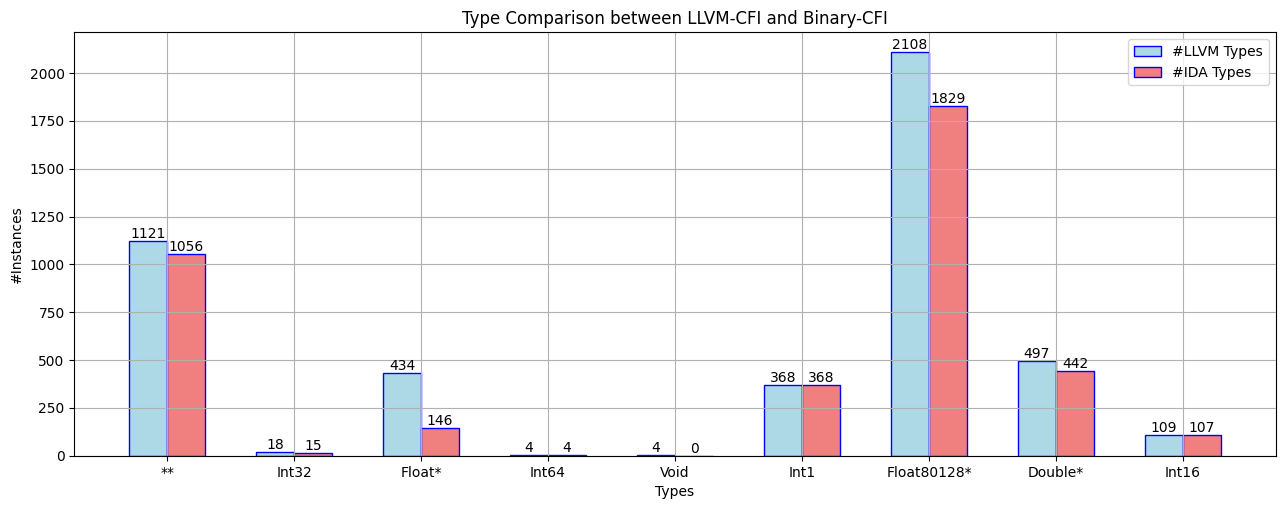

In [139]:
def decode(encoding, recurse):
    ret = ""
    if encoding == 1:
        ret = "Void"
    elif encoding == 2:
        ret = "Int1"
    elif encoding == 3:
        ret = "Int8"
    elif encoding == 4:
        ret = "Int16"
    elif encoding == 5:
        ret = "Int32"
    elif encoding == 6:
        ret = "Int64"
    elif encoding == 7:
        ret = "Half"
    elif encoding == 8:
        ret = "Float"
    elif encoding == 9:
        ret = "Double"
    elif encoding == 10:
        ret = "Float80128"
    elif encoding == 12:
        ret = "Struct"
    elif encoding == 13:
        ret = "Array"
    elif encoding == 14:
        ret = "Undef."
    else:
        if recurse: 
            ret = decode(encoding-11, False)
        ret += "*"
    return ret

def typeMatchPlot(bench, obj):
    dic = obj.callsite_dict
    type_llvm = {}
    type_ida = {}
    for benchmark, df in dic.items():
        print(benchmark)
        for index, row in df.iterrows():
            # Collct and store llvm types - first 1-9 cols.
            for i in range(1,9):
                if row.iloc[i] in [0,32] or row.iloc[i+9] in [0,32]:
                    continue
                decoded_llvm = decode(row.iloc[i], True)
                decoded_ida = decode(row.iloc[i+9], True)
                if decoded_llvm in type_llvm:
                    type_llvm[decoded_llvm] += 1
                else:
                    type_llvm[decoded_llvm] = 1
                if decoded_ida == decoded_llvm:
                    if decoded_ida in type_ida:
                        type_ida[decoded_ida] += 1
                    else:
                        type_ida[decoded_ida] = 1
    
    for k in type_llvm:
        if k not in type_ida:
            type_ida[k] = 0
    
    print(sorted(type_llvm))
    print(sorted(type_ida))
    
    y1 = [type_llvm[k] for k in sorted(type_llvm)]
    y2 = [type_ida[k] for k in sorted(type_ida)]
    
    # Set the bar width.
    w = 0.3
    
    bar1 = np.arange(len(type_llvm))
    bar2 = [i+w for i in bar1]
    
    fig, ax = plt.subplots()
    
    fig.set_dpi(100)
    fig.set_size_inches(15.5, 5.5)
    
    color = ['red','blue','green','orange']
    
    ax_bar1 = ax.bar(bar1, y1,w, label="#LLVM Types", color="lightblue", edgecolor="b")
    ax_bar2 = ax.bar(bar2, y2,w, label="#IDA Types", color="lightcoral", edgecolor="b")
    
    ax.set_xticks(bar1+w/2, type_llvm.keys())
    ax.set_ylabel(f"#Instances")
    ax.set_xlabel("Types")
    ax.set_title(f"Type Comparison between LLVM-CFI and Binary-CFI")
    ax.legend()
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom')
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    plt.grid()
    plt.show()
    plt.close(fig)

typeMatchPlot("spec-opt", spec_opt)

In [141]:
os.getcwd()

'/nfs/volatile/zephyr/Ruturaj/cfi_project/framework/notebooks'